In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, accuracy_score, recall_score,precision_score
from sklearn.preprocessing import StandardScaler, normalize

### On active l'utilisation du GPU pour accélérer l'entrainement des modèles

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
mirrored_strategy = tf.distribute.MirroredStrategy()

Num GPUs Available:  1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


### On récupère les données

In [3]:
test_data = pd.read_csv('./data/exoTest.csv')
train_data = pd.read_csv('./data/exoTrain.csv')

### Exploration des données

#### Aperçu des données

In [4]:
train_data

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,1,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,1,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,1,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


In [5]:
test_data

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,...,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,...,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,...,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,...,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,...,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,1,374.46,326.06,319.87,338.23,251.54,209.84,186.35,167.46,135.45,...,-123.55,-166.90,-222.44,-209.71,-180.16,-166.83,-235.66,-213.63,-205.99,-194.07
566,1,-0.36,4.96,6.25,4.20,8.26,-9.53,-10.10,-4.54,-11.55,...,-12.40,-5.99,-17.94,-11.96,-12.11,-13.68,-3.59,-5.32,-10.98,-11.24
567,1,-54.01,-44.13,-41.23,-42.82,-39.47,-24.88,-31.14,-24.71,-13.12,...,-0.73,-1.64,1.58,-4.82,-11.93,-17.14,-4.25,5.47,14.46,18.70
568,1,91.36,85.60,48.81,48.69,70.05,22.30,11.63,37.86,28.27,...,2.44,11.53,-16.42,-17.86,21.10,-10.25,-37.06,-8.43,-6.48,17.60


In [6]:
columns = list(train_data.columns)

#### On observe la répartition des données

1    5050
2      37
Name: LABEL, dtype: int64


Text(0.5, 1.0, 'Stars Distribution \n (0: Etoiles sans exoplanètes || 1: Etoiles avec exoplanètes)')

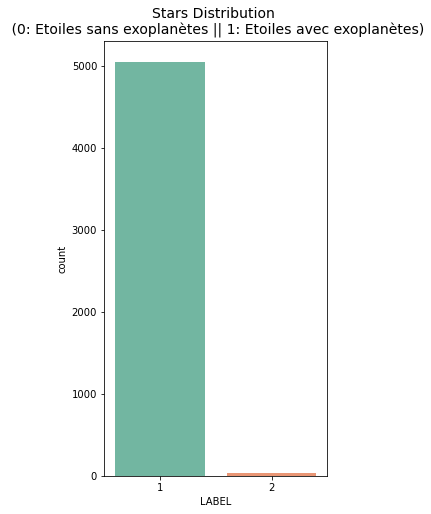

In [7]:
plt.figure(figsize=(4,8))
colors = ["0", "1"]
sns.countplot(x='LABEL', data=train_data, palette = "Set2")
print(train_data['LABEL'].value_counts())
plt.title('Stars Distribution \n (0: Etoiles sans exoplanètes || 1: Etoiles avec exoplanètes)', fontsize=14)

#### Les données sont nettoyées mais on vérifie qu'il n'y a pas de données manquantes au cas où

In [8]:
print("Nombre de valeurs nulles : " + str(train_data.isnull().sum().sum()))

Nombre de valeurs nulles : 0


### Affichage des corrélations

In [9]:
corrMatrix = train_data.corr()
corrMatrix['LABEL'].sort_values(ascending=False) 

LABEL        1.000000
FLUX.1611    0.023127
FLUX.1612    0.022477
FLUX.3054    0.019977
FLUX.1568    0.018600
               ...   
FLUX.2735   -0.019206
FLUX.2811   -0.020379
FLUX.2588   -0.022310
FLUX.2846   -0.023387
FLUX.2875   -0.035607
Name: LABEL, Length: 3198, dtype: float64

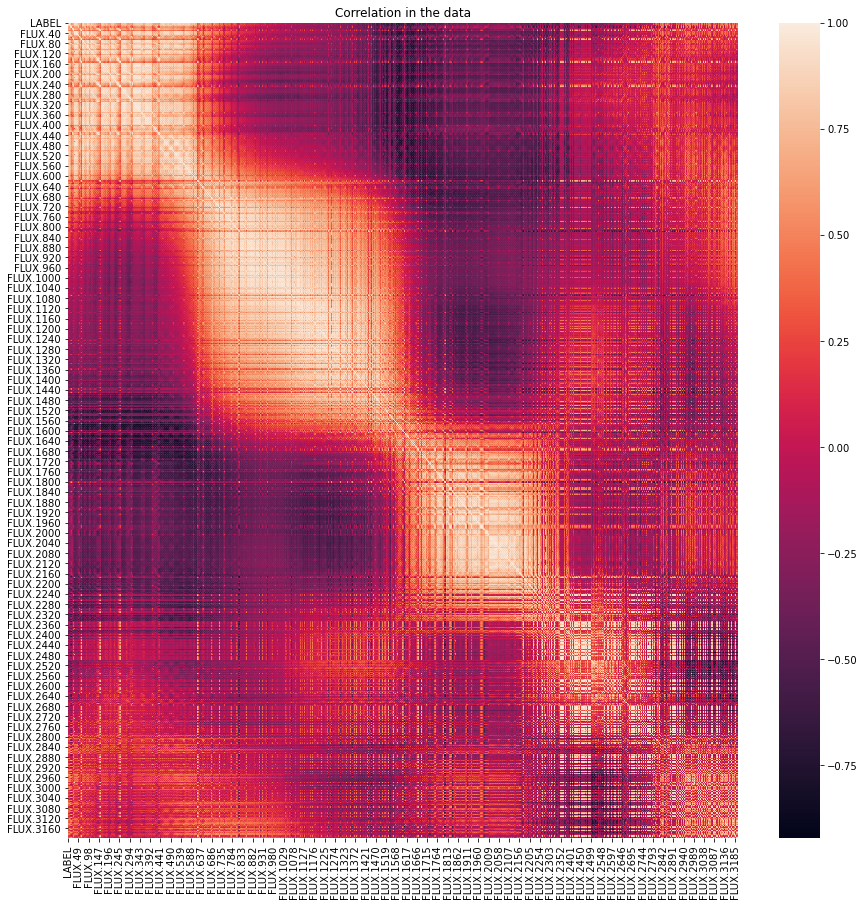

In [10]:
plt.figure(figsize=(15,15))
sns.heatmap(train_data.corr())
plt.title('Correlation in the data')
plt.show()

### On sait que les étoiles ayant potentiellement des exoplanètes en orbites autour d'elles subissent une variation de leur "flux", de leur intensité lumineuse

##### Commençons avec les étoiles ne possédant pas d'exploplanetes

In [11]:
train_data.loc[train_data['LABEL'] == 1]

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
37,1,-141.22,-81.79,-52.28,-32.45,-1.55,-35.61,-23.28,19.45,53.11,...,-50.79,-22.34,-36.23,27.44,13.52,38.66,-17.53,31.49,31.38,50.03
38,1,-35.62,-28.55,-27.29,-28.94,-15.13,-51.06,2.67,-5.21,9.67,...,-43.98,-38.22,-46.23,-54.40,-23.51,-26.96,-3.95,-0.34,10.52,-7.69
39,1,142.40,137.03,93.65,105.64,98.22,99.06,86.40,60.78,45.18,...,-0.99,-3.03,-30.27,-24.22,-35.10,-39.64,23.78,23.40,-0.50,0.97
40,1,-167.02,-137.65,-150.05,-136.85,-98.73,-103.14,-107.70,-123.19,-125.65,...,-97.43,-79.79,-80.62,-78.22,-105.06,-69.67,-90.45,-73.67,-66.71,-66.07
41,1,207.74,223.60,246.15,224.06,210.77,189.56,172.68,170.31,148.79,...,-53.06,-136.92,-174.97,-180.46,-164.01,-126.58,84.05,63.81,108.36,78.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,1,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,1,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,1,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


##### On sélectionne 3 étoiles parmi les concernées (ici la ligne 37,2500 et 5086)

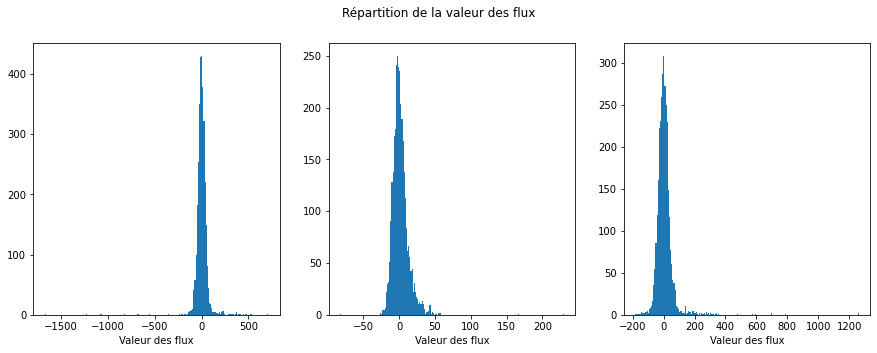

In [12]:
# labels_1=[37,2500,5086]


fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist(train_data.iloc[37,:], bins=200)
ax[1].hist(train_data.iloc[2500,:], bins=200)
ax[2].hist(train_data.iloc[5086,:], bins=200)

ax[0].set_xlabel("Valeur des flux")
ax[1].set_xlabel("Valeur des flux")
ax[2].set_xlabel("Valeur des flux")
fig.suptitle("Répartition de la valeur des flux")

plt.show()

##### On remarque que l'intensité lumineuse de ces étoiles ne varie pas ou très peu

#### Au tour des étoiles dont on sait qu'elles possèdent des exoplanetes en orbite

In [13]:
train_data.loc[train_data['LABEL'] == 2]

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
5,2,211.10,163.57,179.16,187.82,188.46,168.13,203.46,178.65,166.49,...,-98.45,30.34,30.34,29.62,28.80,19.27,-43.90,-41.63,-52.90,-16.16
6,2,9.34,49.96,33.30,9.63,37.64,20.85,4.54,22.42,10.11,...,-58.56,9.93,9.93,23.50,5.28,-0.44,10.90,-11.77,-9.25,-36.69
7,2,238.77,262.16,277.80,190.16,180.98,123.27,103.95,50.70,59.91,...,-72.48,31.77,31.77,53.48,27.88,95.30,48.86,-10.62,-112.02,-229.92
8,2,-103.54,-118.97,-108.93,-72.25,-61.46,-50.16,-20.61,-12.44,1.48,...,43.92,7.24,7.24,-7.45,-18.82,4.53,21.95,26.94,34.08,44.65
9,2,-265.91,-318.59,-335.66,-450.47,-453.09,-561.47,-606.03,-712.72,-685.97,...,3671.03,2249.28,2249.28,2437.78,2584.22,3162.53,3398.28,3648.34,3671.97,3781.91


##### On sélectionne 3 étoiles parmi les concernées (ici la ligne 0,26 et 34)

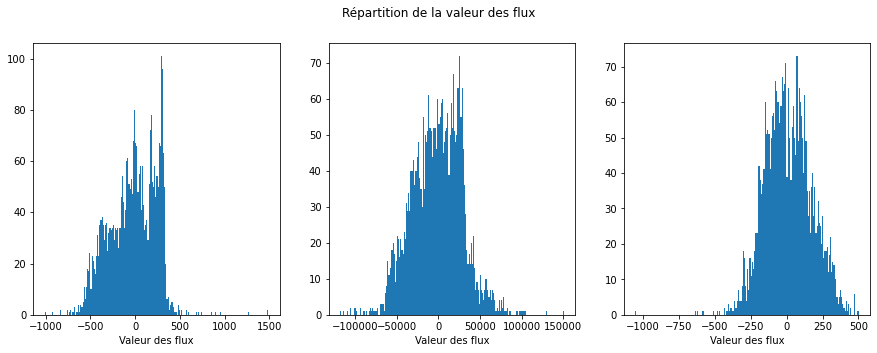

In [14]:
# labels_1=[34,26,0]

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist(train_data.iloc[34,:], bins=200)
ax[1].hist(train_data.iloc[26,:], bins=200)
ax[2].hist(train_data.iloc[0,:], bins=200)

ax[0].set_xlabel("Valeur des flux")
ax[1].set_xlabel("Valeur des flux")
ax[2].set_xlabel("Valeur des flux")
fig.suptitle("Répartition de la valeur des flux")

plt.show()

#### A l'inverses des étoiles n'ayant pas d'exoplanètes, on observe ici une importante variation de l'intensité lumineuse

## On montre la variation des flux lumineux

### Tout d'abord d'une des étoiles ayant des exoplanètes

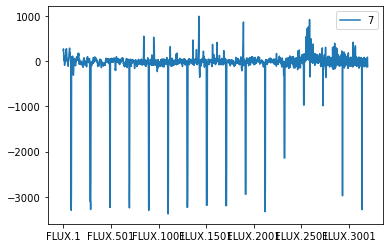

In [15]:
show = train_data[7:8].copy()
show = show.T
show = show[1:-1]
ax2 = show.plot()

### On repère une récurence dans la variation de sa luminosité

### Ensuite sur une étoile n'ayant pas d'éxoplanètes

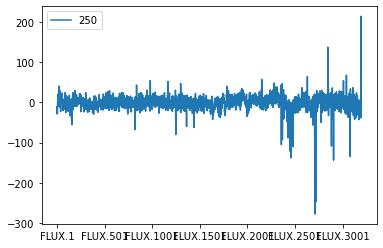

In [16]:
show = train_data[250:251].copy()

show = show.T
show = show[1:-1]
ax2 = show.plot()

### Il serait possible qu'une étoile aie été mal classifiée, si on observer la 372è entrée on obtient ceci :

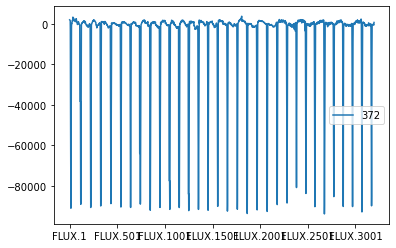

In [17]:
a = test_data[372:373].copy()
# show
a = a.T
a = a[1:-1]
ax2 = a.plot()

#### Elle est pourtant classifiée comme ne possédant pas d'exoplanètes malgré le pattern de variation de sa luminosité

In [18]:
test_data[372:373]

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
372,1,1968.91,1914.66,1897.09,1773.5,1732.06,1594.63,1494.91,-2602.34,-15632.94,...,-130.87,-143.59,-313.56,-471.97,-546.81,-623.09,322.53,438.84,687.78,785.25


### Préparation des données

#### On convertit les valeurs du Label en binaire pour faciliter le traitement des données

In [19]:
label_change = {1: 0,2: 1}
train_data.LABEL = [label_change[item] for item in train_data.LABEL]
test_data.LABEL = [label_change[item] for item in test_data.LABEL]

In [20]:
train_data

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,1,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,1,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,1,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,0,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,0,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,0,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,0,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


In [21]:
test_data

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,...,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,1,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,...,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,1,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,...,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,1,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,...,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,1,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,...,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,0,374.46,326.06,319.87,338.23,251.54,209.84,186.35,167.46,135.45,...,-123.55,-166.90,-222.44,-209.71,-180.16,-166.83,-235.66,-213.63,-205.99,-194.07
566,0,-0.36,4.96,6.25,4.20,8.26,-9.53,-10.10,-4.54,-11.55,...,-12.40,-5.99,-17.94,-11.96,-12.11,-13.68,-3.59,-5.32,-10.98,-11.24
567,0,-54.01,-44.13,-41.23,-42.82,-39.47,-24.88,-31.14,-24.71,-13.12,...,-0.73,-1.64,1.58,-4.82,-11.93,-17.14,-4.25,5.47,14.46,18.70
568,0,91.36,85.60,48.81,48.69,70.05,22.30,11.63,37.86,28.27,...,2.44,11.53,-16.42,-17.86,21.10,-10.25,-37.06,-8.43,-6.48,17.60


### On a pu remarquer des anomalies dans les données (les flux), on peut donc essayer de visualiser cela avec des boites à moustache

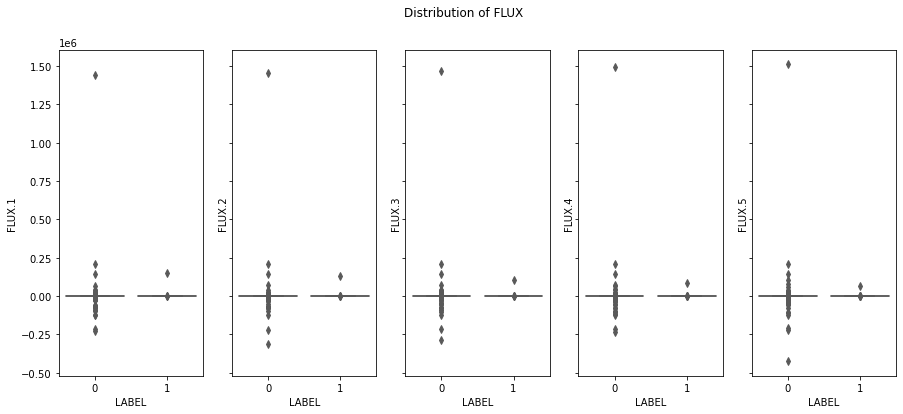

In [22]:
fig, axes = plt.subplots(1, 5,figsize=(15, 6), sharey=True)
fig.suptitle('Distribution of FLUX')

sns.boxplot(ax=axes[0], data=train_data, x='LABEL', y='FLUX.1',palette="Set2")
sns.boxplot(ax=axes[1], data=train_data, x='LABEL', y='FLUX.2',palette="Set2")
sns.boxplot(ax=axes[2], data=train_data, x='LABEL', y='FLUX.3',palette="Set2")
sns.boxplot(ax=axes[3], data=train_data, x='LABEL', y='FLUX.4',palette="Set2")
sns.boxplot(ax=axes[4], data=train_data, x='LABEL', y='FLUX.5',palette="Set2")

#### On remarque donc des anomalies (des outliers), notamment pour les étoiles ne possédant pas d'exoplanetes, que l'on va retirer car ils peuvent perturber l'apprentissage du model plus tard

#### Retrait des anomalies (outliers)

In [23]:
def remove_outliers(df):
    for col in df.columns:
#         print("capping the ",col)
        if (col != 'LABEL'):
            percentiles = df[col].quantile([0.02,0.98]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df



final_train = remove_outliers(train_data)

C:\Users\beren\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\beren\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


##### on retire les 2% des valeurs les plus hautes et les plus basses pour les remplacer par les valeurs les plus proches

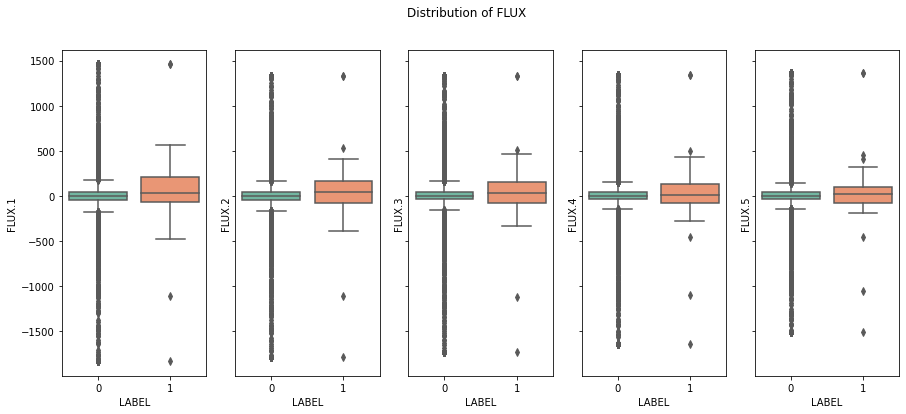

In [24]:
fig, axes = plt.subplots(1, 5,figsize=(15, 6), sharey=True)
fig.suptitle('Distribution of FLUX')

sns.boxplot(ax=axes[0], data=train_data, x='LABEL', y='FLUX.1',palette="Set2")
sns.boxplot(ax=axes[1], data=train_data, x='LABEL', y='FLUX.2',palette="Set2")
sns.boxplot(ax=axes[2], data=train_data, x='LABEL', y='FLUX.3',palette="Set2")
sns.boxplot(ax=axes[3], data=train_data, x='LABEL', y='FLUX.4',palette="Set2")
sns.boxplot(ax=axes[4], data=train_data, x='LABEL', y='FLUX.5',palette="Set2")

##### On affiche la moyenne de variation lumineuse des étoiles possédant une ou des exoplanète(s)

In [25]:
train_data.loc[train_data['LABEL'] == 1].std(axis=1).mean()

231.22349548241382

##### On affiche la moyenne de variation lumineuse des étoiles ne possédant pas d'exoplanètes

In [26]:
train_data.loc[train_data['LABEL'] == 0].std(axis=1).mean()

122.93167610334919

#### On observe que la variation lumineuse des étoiles possédant des exoplanètes est 2 fois plus importante

### On va split le dataset pour travailler dessus et pouvoir préparer le model

In [27]:
X_train = train_data.drop(["LABEL"],axis=1)
y_train = train_data["LABEL"]   
X_test = test_data.drop(["LABEL"],axis=1)
y_test = test_data["LABEL"]

### Normalisation de la donnée

#### On va normaliser les données pour la préparer pour le machine learning. L'idée est d'organiser toutes les données dans un même fourchette pour faciliter l'apprentissage (tout en gardant les ordres de grandeur)

In [28]:
X_train = normalize(X_train)
X_test = normalize(X_test)

### Feature scaling

In [29]:
std_scaler = StandardScaler()
X_train = scaled = std_scaler.fit_transform(X_train)
X_test = std_scaler.fit_transform(X_test)

# On définit les modèles qu'on va utiliser

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Test d'algorithme

### Decision Tree

In [31]:
model_DT = DecisionTreeClassifier(random_state=1)

In [32]:
model_DT.fit(X_train, y_train)
print(model_DT.__class__.__name__, model_DT.score(X_test, y_test))
print(confusion_matrix(y_test, model_DT.predict(X_test)))

DecisionTreeClassifier 0.9631578947368421
[[548  17]
 [  4   1]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

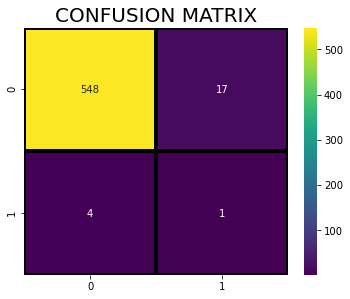

In [33]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_DT.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

## KNN

In [34]:
model_KNN = KNeighborsClassifier(n_jobs=-1)

In [35]:
model_KNN.fit(X_train, y_train)
print(model_KNN.__class__.__name__, model_KNN.score(X_test, y_test))
print(confusion_matrix(y_test, model_KNN.predict(X_test)))

KNeighborsClassifier 0.9912280701754386
[[565   0]
 [  5   0]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

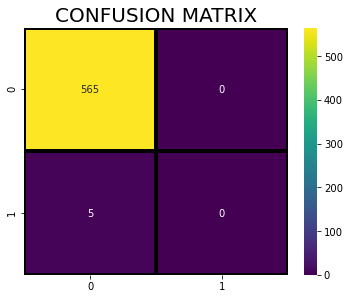

In [36]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_KNN.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

### RandomForest

In [37]:
model_RF = RandomForestClassifier(n_jobs=-1)

In [38]:
model_RF.fit(X_train, y_train)
print(model_RF.__class__.__name__, model_RF.score(X_test, y_test))
print(confusion_matrix(y_test, model_RF.predict(X_test)))

RandomForestClassifier 0.9912280701754386
[[565   0]
 [  5   0]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

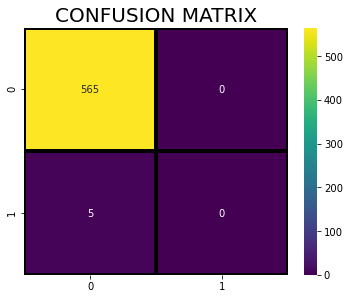

In [39]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_RF.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

###  On arrive pas ou très difficilement à déterminer si une étoile possède des planètes

### Nous sommes en présent d'un accuracy paradox dû au déséquilibre des données

### Comme on l'a vu, l'échantillon est très déséquilibré. On va tenter de rééquilibrer les 2 catégories grâce à un SMOTE pour faciliter l'apprentissage.

## SMOTE

In [40]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [41]:
smote = SMOTE(random_state=1)
train_X, train_y = smote.fit_sample(train_data.drop('LABEL',axis=1), train_data['LABEL'])

In [42]:
train_X

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,93.850000,83.810000,20.100000,-26.980000,-39.560000,-124.710000,-135.180000,-96.270000,-79.890000,-160.170000,...,-78.070000,-102.150000,-102.150000,25.130000,48.570000,92.540000,39.320000,61.420000,5.080000,-39.540000
1,-38.880000,-33.830000,-58.540000,-40.090000,-79.310000,-72.810000,-86.550000,-85.330000,-83.970000,-73.380000,...,-3.280000,-32.210000,-32.210000,-24.890000,-4.860000,0.760000,-11.700000,6.460000,16.000000,19.930000
2,532.640000,535.920000,513.730000,496.920000,456.450000,466.000000,464.500000,486.390000,436.560000,484.390000,...,-71.690000,13.310000,13.310000,-29.890000,-20.880000,5.060000,-11.800000,-28.910000,-70.020000,-96.670000
3,326.520000,347.390000,302.350000,298.130000,317.740000,312.700000,322.330000,311.310000,312.420000,323.330000,...,5.710000,-3.730000,-3.730000,30.050000,20.030000,-12.670000,-8.770000,-17.310000,-17.350000,13.980000
4,-1107.210000,-1112.590000,-1118.950000,-1095.100000,-1057.550000,-1034.480000,-998.340000,-1022.710000,-989.570000,-970.880000,...,-594.370000,-401.660000,-401.660000,-357.240000,-443.760000,-438.540000,-399.710000,-384.650000,-411.790000,-510.540000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10095,-37.762407,-28.610902,-40.350344,-33.142900,-19.153846,-13.976410,-16.842233,-7.074976,-17.221413,6.051566,...,5.469546,-38.654270,-26.475028,-36.629695,-41.661984,-18.543197,-13.295111,-6.905054,1.751265,11.388910
10096,-120.004065,-117.907992,-127.523213,-107.195438,-108.064381,-94.869455,-92.208152,-84.369956,-73.075914,-59.126073,...,21.454404,-40.369773,-40.369773,-42.459509,-54.562003,-53.365841,-36.848303,-24.094639,11.504370,-4.465667
10097,-112.220865,-112.170388,-121.156759,-100.354635,-100.977444,-86.632390,-85.336096,-76.049112,-65.798173,-51.494164,...,21.188318,-41.670656,-41.670656,-46.175459,-55.715523,-53.337255,-36.740186,-24.794328,12.066986,-7.208281
10098,52.866006,58.044512,41.450882,59.999963,34.929451,38.189835,23.149620,27.512235,22.777153,13.410216,...,34.326297,-1.050533,20.141804,-10.788668,-10.071694,8.715645,-5.010329,-10.815657,-1.900401,-13.017458


In [43]:
train_y

0        1
1        1
2        1
3        1
4        1
        ..
10095    1
10096    1
10097    1
10098    1
10099    1
Name: LABEL, Length: 10100, dtype: int64

Text(0.5, 1.0, 'Stars Distribution \n (0: Etoiles sans exoplanètes || 1: Etoiles avec exoplanètes)')

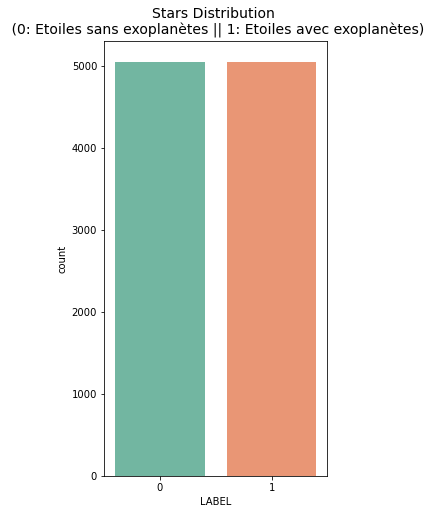

In [44]:
plt.figure(figsize=(4,8))
colors = ["0", "1"]
sns.countplot(x=train_y, palette = "Set2")
plt.title('Stars Distribution \n (0: Etoiles sans exoplanètes || 1: Etoiles avec exoplanètes)', fontsize=14)

### On normalize et on scale

In [45]:
train_X = normalize(train_X)

In [46]:
std_scaler = StandardScaler()
train_X = scaled = std_scaler.fit_transform(train_X)

### On split les données smotée en train et validation

In [47]:
from sklearn.model_selection import train_test_split 

In [48]:
train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=0.1, random_state=42, stratify=train_y)
# 

### Maintenant qu'on a rééquilibré le data set on va pouvoir re-tester

## Decision Tree

In [49]:
model_DT_SMOTE = DecisionTreeClassifier(max_features=200, random_state=42)

In [50]:
model_DT_SMOTE.fit(train_X, train_y)
print(model_DT_SMOTE.__class__.__name__, model_DT_SMOTE.score(test_X, test_y))
print(confusion_matrix(test_y, model_DT_SMOTE.predict(test_X)))

DecisionTreeClassifier 0.9831683168316832
[[488  17]
 [  0 505]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

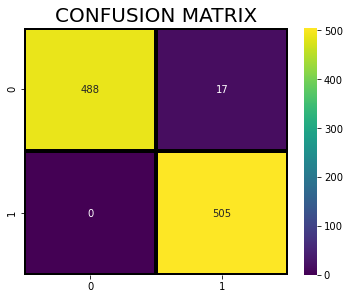

In [51]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(test_y,model_DT_SMOTE.predict(test_X)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

## KNN

In [52]:
model_KNN_SMOTE = KNeighborsClassifier(n_neighbors=4, metric='manhattan', n_jobs=-1)

In [53]:
model_KNN_SMOTE.fit(train_X, train_y)
print(model_KNN_SMOTE.__class__.__name__, model_KNN_SMOTE.score(test_X, test_y))
print(confusion_matrix(test_y, model_KNN_SMOTE.predict(test_X)))

KNeighborsClassifier 0.998019801980198
[[503   2]
 [  0 505]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

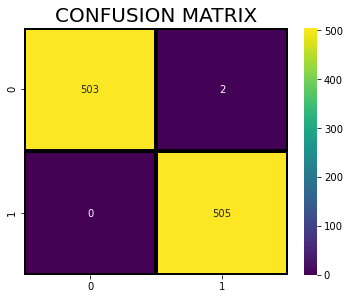

In [54]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(test_y,model_KNN_SMOTE.predict(test_X)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

## Random Forest

In [55]:
model_RF_SMOTE = RandomForestClassifier(n_estimators=2, max_features=200, random_state = 100, n_jobs=-1)

In [56]:
model_RF_SMOTE = model_RF_SMOTE.fit(train_X, train_y)
print(model_RF_SMOTE.__class__.__name__, model_RF_SMOTE.score(test_X, test_y))
print(confusion_matrix(test_y, model_RF_SMOTE.predict(test_X)))

RandomForestClassifier 0.9900990099009901
[[504   1]
 [  9 496]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

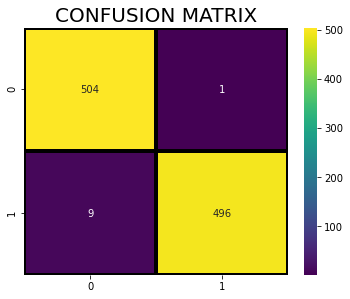

In [57]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(test_y,model_RF_SMOTE.predict(test_X)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

## Logistic Regression

In [58]:
model_LR_SMOTE = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight={0:136, 1:1})

In [59]:
model_LR_SMOTE.fit(train_X, train_y)
print(model_LR_SMOTE.__class__.__name__, model_LR_SMOTE.score(test_X, test_y))
print(confusion_matrix(test_y, model_LR_SMOTE.predict(test_X)))

LogisticRegression 1.0
[[505   0]
 [  0 505]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

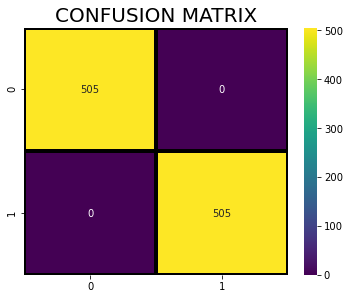

In [60]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(test_y,model_LR_SMOTE.predict(test_X)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

## Voting classifier

In [61]:
#Retrait de l'ensemblevoting classifier car par interessant en terme de résultats

for model in (model_DT_SMOTE, model_KNN_SMOTE,model_RF_SMOTE, model_LR_SMOTE):
    model.fit(train_X, train_y)
    
    print(model.__class__.__name__)
    print('Accuracy score:',accuracy_score(y_test, model.predict(X_test)))
    print('ROCAUC score:',roc_auc_score(y_test, model.predict(X_test)))
    print('Precision score:',precision_score(y_test, model.predict(X_test)))
    print('Recall score:',recall_score(y_test, model.predict(X_test)))
    print('F1 score:',f1_score(y_test, model.predict(X_test)))
    print(confusion_matrix(y_test, model.predict(X_test)))
    print('')

DecisionTreeClassifier
Accuracy score: 0.9210526315789473
ROCAUC score: 0.5637168141592921
Precision score: 0.023809523809523808
Recall score: 0.2
F1 score: 0.0425531914893617
[[524  41]
 [  4   1]]

KNeighborsClassifier
Accuracy score: 0.9894736842105263
ROCAUC score: 0.5982300884955751
Precision score: 0.3333333333333333
Recall score: 0.2
F1 score: 0.25
[[563   2]
 [  4   1]]

RandomForestClassifier
Accuracy score: 0.9631578947368421
ROCAUC score: 0.5849557522123894
Precision score: 0.05555555555555555
Recall score: 0.2
F1 score: 0.08695652173913045
[[548  17]
 [  4   1]]

LogisticRegression
Accuracy score: 0.7403508771929824
ROCAUC score: 0.4725663716814159
Precision score: 0.006896551724137931
Recall score: 0.2
F1 score: 0.013333333333333332
[[421 144]
 [  4   1]]



## Tests de prédiction

In [62]:
def prepare_data(df):

    if 'SAP_FLUX' in df.columns:
        df = transform_to_df(df)

    df = df.dropna(axis=1)
    
    
    if(df.size < 3197):
        print("Pas assez de donnéees")
        return None
    else:
        print("Assez de donnéees, traitement en cours ....")
                  
            
        df = remove_outliers(df)
        
        df_normalized = normalize(df)
        
        std_scaler = StandardScaler()
        df_normalized_scalled = scaled = std_scaler.fit_transform(df_normalized)
        
        df_transformed = pd.DataFrame(df_normalized_scalled) 
    
        if df_transformed.size > 3197:
            df_final = df_transformed[df_transformed.columns[0:3197]]
    
        print("Traitement terminé")
        return df_final

In [63]:
def isexoplanet(model, df):
#     x = np.array(df[0]).reshape(1,3197)
    x = np.array(df).reshape(1, -1)
    
    print(model.predict(x))
    if model.predict(x) == 1:
        print("Cette étoile possède des exoplanètes")
    elif model.predict(x) == 0:
        print("Cette étoile ne possède pas d'exoplanètes")
        
    print(model.predict_proba(x))

In [64]:
y_test[372:373]

372    0
Name: LABEL, dtype: int64

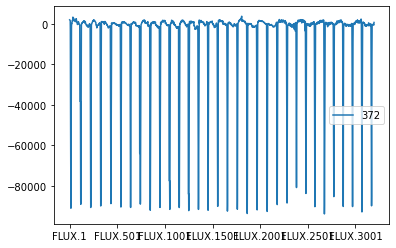

In [65]:
a = test_data[372:373].copy()
# show
a = a.T
a = a[1:-1]
ax2 = a.plot()

In [66]:
isexoplanet(model_RF_SMOTE, X_test[372:373])

[1]
Cette étoile possède des exoplanètes
[[0. 1.]]


In [67]:
y_pred = model_KNN_SMOTE.predict(X_test)

In [68]:
i=0

for i in range(len(y_pred)):
    if y_test[i] ==0 and y_pred[i].T == 1:
        print("False Positive : " + str(i))
    if y_test[i] == 1 and y_pred[i].T == 0 :
        print("False Negative  : " + str(i))
    i+=1

False Negative  : 0
False Negative  : 1
False Negative  : 3
False Negative  : 4
False Positive : 308
False Positive : 560


Text(0.5, 1.0, 'CONFUSION MATRIX')

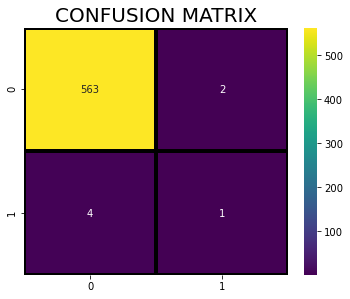

In [69]:
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_KNN_SMOTE.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

In [70]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('Precision score:',precision_score(y_test, y_pred))
print('Recall score:',recall_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))

ROCAUC score: 0.5982300884955751
Accuracy score: 0.9894736842105263
Precision score: 0.3333333333333333
Recall score: 0.2
F1 score: 0.25
